In [74]:
import pyro
import pyro.optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, RenyiELBO
import torch
import torch.distributions.constraints as constraints
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as onp
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano

In [89]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = pd.DataFrame(diabetes['data'], columns = diabetes['feature_names'])
y = pd.DataFrame(diabetes['target'], columns = ['y'])
data = X
data = data * onp.shape(data)[0]
data['y'] = onp.log(y)
data['sex'][data['sex']>0] = 1
data['sex'][data['sex']<0] = 0
train, test = train_test_split(data, test_size=0.2)

In [92]:
def model(age, sex, bmi, bp, y):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_age = pyro.sample("b_age", dist.Normal(0., 1.))
    b_sex = pyro.sample("b_sex", dist.Normal(0., 1.))
    b_bmi = pyro.sample("b_bmi", dist.Normal(0., 1.))
    b_bp = pyro.sample("b_bp", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Gamma(10., 10.))
    mean = a + b_age * age + b_sex * sex + b_bmi * bmi + b_bp * bp
    with pyro.plate("data", len(age)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

In [93]:
def guide(age, sex, bmi, bp, y):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(4))
    weights_scale = pyro.param('weights_scale', torch.ones(4),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_age = pyro.sample("b_age", dist.Normal(weights_loc[0], weights_scale[0]))
    b_sex = pyro.sample("b_sex", dist.Normal(weights_loc[1], weights_scale[1]))
    b_bmi = pyro.sample("b_bmi", dist.Normal(weights_loc[2], weights_scale[2]))
    b_bp = pyro.sample("b_bp", dist.Normal(weights_loc[3], weights_scale[3]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_age * age + b_sex * sex + b_bmi * bmi + b_bp * bp

In [94]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [ ]:
# Prepare training data
train = train[["age","sex","bmi","bp","y"]]
test = test[["age","sex","bmi","bp","y"]]
train = torch.tensor(train.values, dtype=torch.float)

In [102]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=RenyiELBO(alpha=2))
          #loss=Trace_ELBO())

age, sex, bmi, bp, y = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4]
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(age, sex, bmi, bp, y)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 316858.375
Elbo loss: 1288.8046875
Elbo loss: 1284.5126953125
Elbo loss: 1043.556640625
Elbo loss: 974.1082153320312
Elbo loss: 919.7875366210938
Elbo loss: 870.862060546875
Elbo loss: 650.3508911132812
Elbo loss: 541.068359375
Elbo loss: 437.44683837890625


In [103]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(y, age, sex, bmi, bp).items()
               if k != "obs"}

In [104]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  4.951526  0.039177  4.888011  4.924976  4.951447  4.975773  5.017786 

Site: b_age
       mean       std        5%       25%       50%       75%       95%
0 -0.005304  0.006311 -0.015589 -0.009636 -0.005315 -0.000935  0.004904 

Site: b_sex
       mean       std        5%       25%       50%       75%       95%
0 -0.043394  0.047658 -0.120202 -0.073071 -0.044633 -0.009956  0.034598 

Site: b_bmi
       mean       std        5%       25%       50%      75%       95%
0  0.006106  0.006731 -0.004895  0.001643  0.006102  0.01031  0.017769 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0 -0.011079  0.006169 -0.021225 -0.015101 -0.011151 -0.006889 -0.001134 

Site: sigma
       mean       std        5%       25%       50%      75%      95%
0  0.747541  0.050037  0.662794  0.713548  0.750076  0.78264  0.82305 



In [83]:
# HMC comparison
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(age, sex, bmi, bp, y)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [01:45, 11.34it/s, step size=8.34e-02, acc. prob=0.931]


In [84]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
      mean       std        5%       25%       50%       75%       95%
0  4.94896  0.032768  4.896279  4.925363  4.949108  4.971168  5.003539 

Site: b_age
       mean       std        5%       25%       50%       75%       95%
0  0.000171  0.001176 -0.001787 -0.000626  0.000175  0.000928  0.002065 

Site: b_sex
      mean       std        5%       25%       50%       75%       95%
0 -0.10216  0.049643 -0.185893 -0.136423 -0.101841 -0.066708 -0.023419 

Site: b_bmi
       mean       std        5%       25%       50%      75%     95%
0  0.011317  0.001236  0.009224  0.010501  0.011316  0.01213  0.0134 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0  0.007086  0.001306  0.005026  0.006213  0.007042  0.007972  0.009278 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.438757  0.016214  0.413556  0.427104  0.437837  0.449925  0.466638 



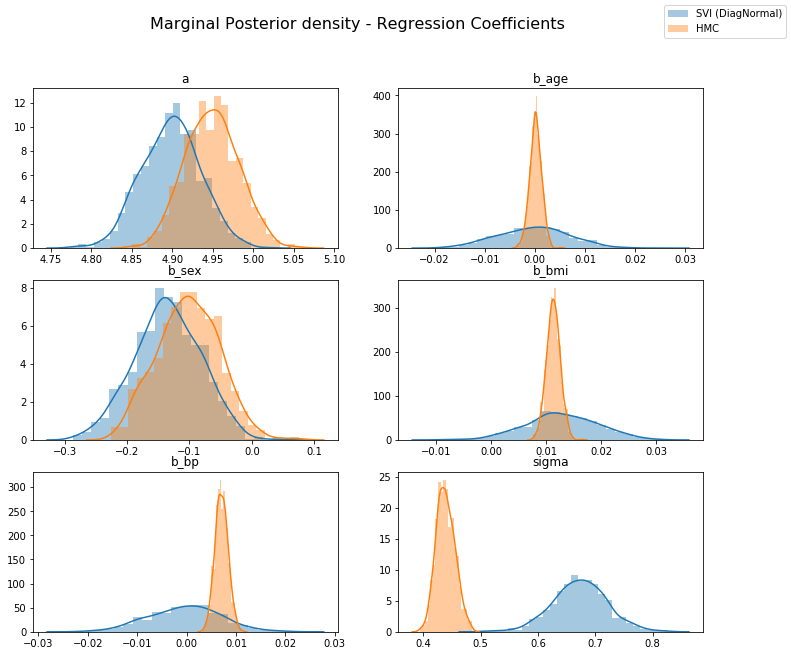

In [85]:
sites = ["a", "b_age", "b_sex", "b_bmi", "b_bp", "sigma"]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');